# LangChain: Q&A over Documents

An example might be a tool that would allow you to query a product catalog for items of interest.

In [1]:
#pip install --upgrade langchain
#!pip install tiktoken

In [2]:
import openai
import os
import json

# Open the JSON file
with open('/Users/edwin/Repositories/api_keys.json') as file:
    data = json.load(file)

# Access the API keys
openai.api_key= data['apiKeys']['OpenAI']

os.environ["OPENAI_API_KEY"] = data['apiKeys']['OpenAI']

In [3]:
from langchain.chains import RetrievalQA #Retrieval of different documents (a csv in this case)
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown

In [4]:
file = 'OutdoorClothingCatalog_1000.csv' #CSV loader
loader = CSVLoader(file_path=file, encoding='utf-8')

In [5]:
from langchain.indexes import VectorstoreIndexCreator #Help us create a vector store

In [6]:
#pip install docarray

In [7]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader]) #Loaders are the list of documents

In [8]:
query ="Please list all your shirts with sun protection \
in a table in markdown and summarize each one."

In [9]:
response = index.query(query)

We got a table with all stuff with sun protection

In [10]:
display(Markdown(response))



| Name | Description |
| --- | --- |
| Men's Tropical Plaid Short-Sleeve Shirt | UPF 50+ rated sun protection, 100% polyester fabric, wrinkle-resistant, front and back cape venting, two front bellows pockets |
| Men's Plaid Tropic Shirt, Short-Sleeve | UPF 50+ rated sun protection, 52% polyester and 48% nylon fabric, wrinkle-free, quickly evaporates perspiration, front and back cape venting, two front bellows pockets |
| Sun Shield Shirt by | UPF 50+ rated sun protection, 78% nylon and 22% Lycra Xtra Life fiber fabric, wicks moisture for quick-drying comfort, abrasion resistant, fits comfortably over swimsuit |
| Men's TropicVibe Shirt, Short-Sleeve | UPF 50+ rated sun protection, 71% Nylon and 29% Polyester fabric, wrinkle resistant, front and back cape venting, two front bellows pockets |

All of these shirts provide UPF 50+ rated sun protection, blocking 98% of the sun's harmful rays. They are made of various fabrics, such as polyester, nylon,

How can the llm can read all?

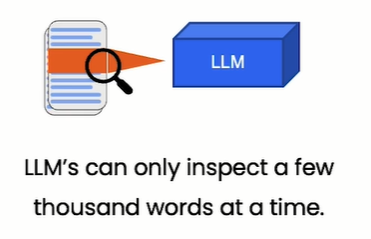

By embeddings. By vectorization. Text with similar content will have similar vectors.

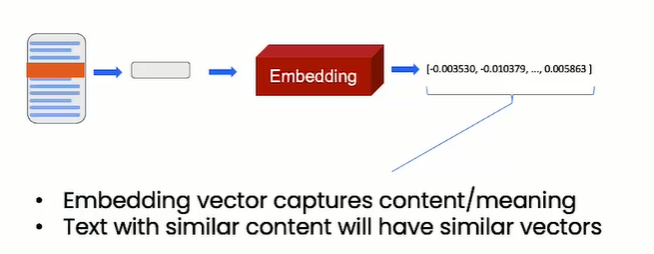

3 sentences, for this example. It compare the similarity of each sentence.

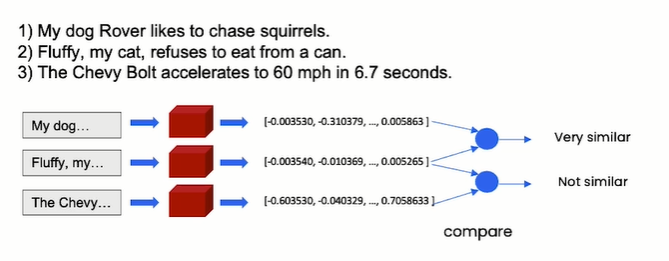

We create chunks and then an embedding for each chunk.

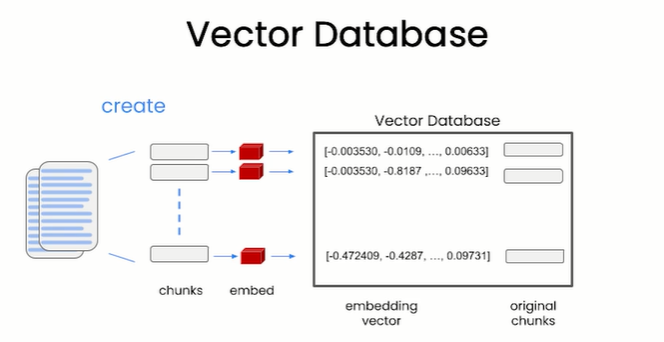

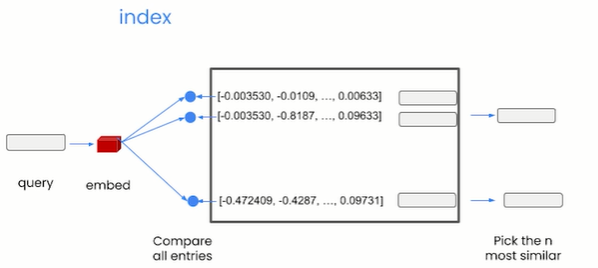

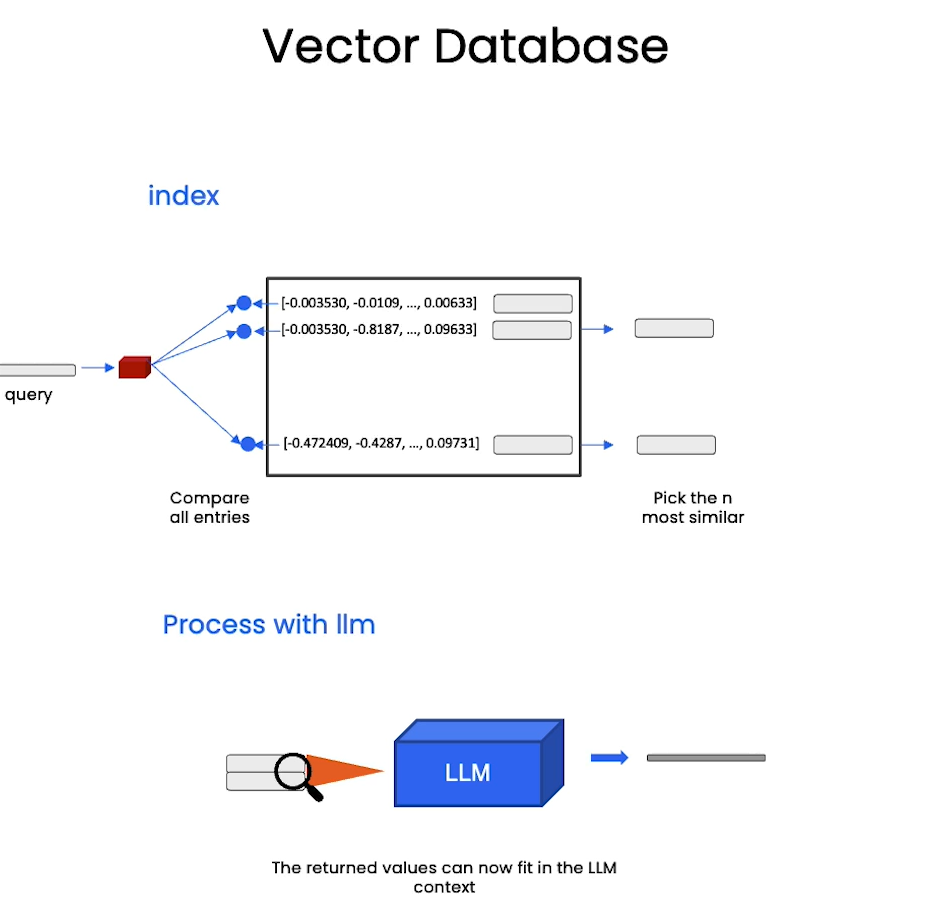

In [11]:
loader = CSVLoader(file_path="OutdoorClothingCatalog_1000.csv", encoding='utf-8')

In [12]:
docs = loader.load()

In [13]:
docs[0]

Document(page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \r\n\r\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \r\n\r\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \r\n\r\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \r\n\r\nQuestions? Please contact us for any inquiries.", metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 0})

In [14]:
from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

We create a simple embed

In [15]:
embed = embeddings.embed_query("Hi my name is Harrison")

And find that there are 1536 embeddings similar to that.

In [16]:
print(len(embed))

1536


We can see that numerical representations.

In [17]:
print(embed[:5])

[-0.021913960576057434, 0.006774206645786762, -0.018190348520874977, -0.039148248732089996, -0.014089343138039112]


In the following example we can search by similarity:

In [18]:
db = DocArrayInMemorySearch.from_documents(
    docs, 
    embeddings
)

In [19]:
query = "Please suggest a shirt with sunblocking"

In [20]:
docs = db.similarity_search(query)

We get only 4 documents.

In [21]:
len(docs)

4

In [22]:
docs[0]

Document(page_content=': 255\nname: Sun Shield Shirt by\ndescription: "Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. \r\n\r\nSize & Fit: Slightly Fitted: Softly shapes the body. Falls at hip.\r\n\r\nFabric & Care: 78% nylon, 22% Lycra Xtra Life fiber. UPF 50+ rated – the highest rated sun protection possible. Handwash, line dry.\r\n\r\nAdditional Features: Wicks moisture for quick-drying comfort. Fits comfortably over your favorite swimsuit. Abrasion resistant for season after season of wear. Imported.\r\n\r\nSun Protection That Won\'t Wear Off\r\nOur high-performance fabric provides SPF 50+ sun protection, blocking 98% of the sun\'s harmful rays. This fabric is recommended by The Skin Cancer Foundation as an effective UV protectant.', metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 255})

Como lo usamos para hacer preguntas y respuestas? Primeros tenemos que crear un retriever para el vector store.

In [23]:
retriever = db.as_retriever()

Como queremos obtener estos a traves del uso de un llm, importamos chatopenai

In [24]:
llm = ChatOpenAI(temperature = 0.0)

In [25]:
qdocs = "".join([docs[i].page_content for i in range(len(docs))]) # We combine everything into a variable.

In [26]:
qdocs

': 255\nname: Sun Shield Shirt by\ndescription: "Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. \r\n\r\nSize & Fit: Slightly Fitted: Softly shapes the body. Falls at hip.\r\n\r\nFabric & Care: 78% nylon, 22% Lycra Xtra Life fiber. UPF 50+ rated – the highest rated sun protection possible. Handwash, line dry.\r\n\r\nAdditional Features: Wicks moisture for quick-drying comfort. Fits comfortably over your favorite swimsuit. Abrasion resistant for season after season of wear. Imported.\r\n\r\nSun Protection That Won\'t Wear Off\r\nOur high-performance fabric provides SPF 50+ sun protection, blocking 98% of the sun\'s harmful rays. This fabric is recommended by The Skin Cancer Foundation as an effective UV protectant.: 374\nname: Men\'s Plaid Tropic Shirt, Short-Sleeve\ndescription: Our Ultracomfortable sun protection is rated to UPF 50+, helping you stay cool and dry. Originally designed for fishing, this lightest hot-weather shir

In [27]:
response = llm.call_as_llm(f"Please list all your \
shirts with sun protection in a table in markdown and summarize each one in less than 60 words.\
The data is the following: {qdocs} ") 
#That we must add to the llm

In [28]:
display(Markdown(response))

| Name | Description |
|------|-------------|
| Sun Shield Shirt | A high-performance sun shirt that provides UPF 50+ sun protection. It is made of nylon and Lycra Xtra Life fiber, wicks moisture for quick-drying comfort, and fits comfortably over swimsuits. It is recommended by The Skin Cancer Foundation. |
| Men's Plaid Tropic Shirt | This short-sleeve shirt offers UPF 50+ sun protection and is designed for fishing and extended travel. It is made of polyester and nylon, wrinkle-free, and quickly evaporates perspiration. It features front and back cape venting and two front bellows pockets. |
| Men's TropicVibe Shirt | A sun-protection shirt with built-in UPF 50+ that has a lightweight feel and provides coverage. It is made of nylon and polyester, wrinkle-resistant, and has front and back cape venting and two front bellows pockets. |
| Men's Tropical Plaid Short-Sleeve Shirt | The lightest hot-weather shirt with UPF 50+ sun protection. It is made of polyester, wrinkle-resistant, and has front and back cape venting and two front bellows pockets. |

Note: All shirts provide SPF 50+ sun protection, blocking 98% of the sun's harmful rays.

In [29]:
qa_stuff = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever, 
    verbose=True
)

In [30]:
query =  "Please list all your shirts with sun protection in a table \
in markdown and summarize each one in less than 60 words."

In [31]:
#response = qa_stuff.run(query)



> Entering new  chain...


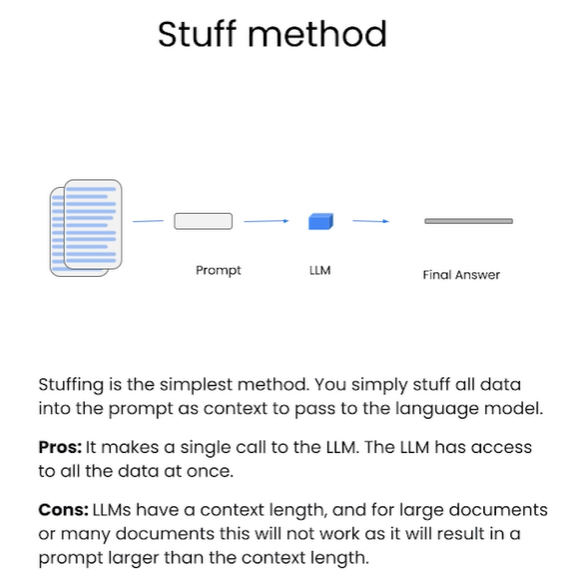

In [31]:
display(Markdown(response))

| Shirt Number | Name | Description |
| --- | --- | --- |
| 618 | Men's Tropical Plaid Short-Sleeve Shirt | This shirt is made of 100% polyester and is wrinkle-resistant. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays. |
| 374 | Men's Plaid Tropic Shirt, Short-Sleeve | This shirt is made with 52% polyester and 48% nylon. It is machine washable and dryable. It has front and back cape venting, two front bellows pockets, and is rated to UPF 50+. |
| 535 | Men's TropicVibe Shirt, Short-Sleeve | This shirt is made of 71% Nylon and 29% Polyester. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays. |
| 255 | Sun Shield Shirt | This shirt is made of 78% nylon and 22% Lycra Xtra Life fiber. It is handwashable and line dry. It is rated UPF 50+ for superior protection from the sun's UV rays. It is abrasion-resistant and wicks moisture for quick-drying comfort. |

The Men's Tropical Plaid Short-Sleeve Shirt is made of 100% polyester and is wrinkle-resistant. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays.

The Men's Plaid Tropic Shirt, Short-Sleeve is made with 52% polyester and 48% nylon. It has front and back cape venting, two front bellows pockets, and is rated to UPF 50+.

The Men's TropicVibe Shirt, Short-Sleeve is made of 71% Nylon and 29% Polyester. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays.

The Sun Shield Shirt is made of 78% nylon and 22% Lycra Xtra Life fiber. It is abrasion-resistant and wicks moisture for quick-drying comfort. It is rated UPF 50+ for superior protection from the sun's UV rays. It is handwashable and line dry.

In [31]:
response = index.query(query, llm=llm)

In [33]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=embeddings,
).from_loaders([loader])

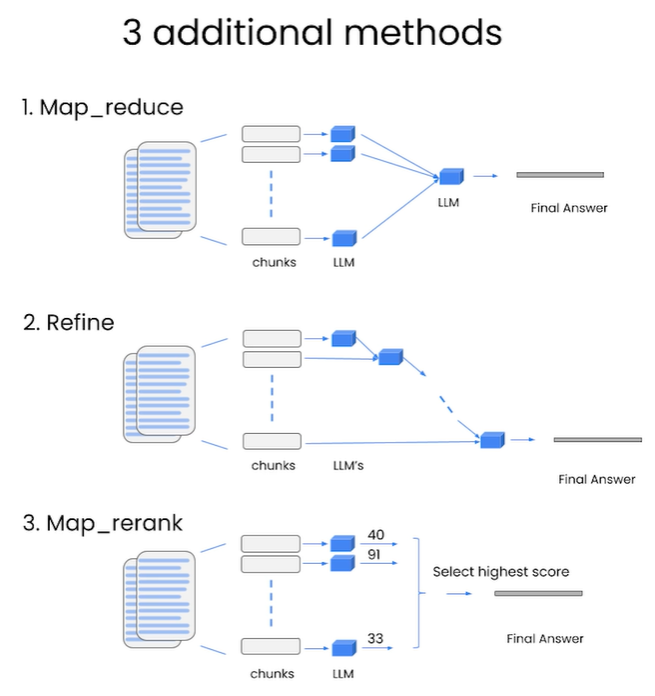